In [41]:
import pandas as pd

# 파일 불러오기

In [42]:
df = pd.read_csv('movies_1980_2025.csv')

In [43]:
df.columns

Index(['Title', 'Year', 'MPA', 'Rating', 'Votes', 'writers', 'directors',
       'stars', 'countries_origin', 'production_company', 'Languages',
       'Duration_minute', 'budget_usd', 'genres_imdb', 'popularity_score'],
      dtype='object')

# XGBoost

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [45]:
df.columns

Index(['Title', 'Year', 'MPA', 'Rating', 'Votes', 'writers', 'directors',
       'stars', 'countries_origin', 'production_company', 'Languages',
       'Duration_minute', 'budget_usd', 'genres_imdb', 'popularity_score'],
      dtype='object')

In [46]:
df = df[[ 'MPA','Duration_minute', 'genres_imdb', 'popularity_score']]
df

,MPA,Duration_minute,genres_imdb,popularity_score
0,PG,124.0,"['Action', 'Adventure', 'Fantasy']",12180000.0
1,PG,127.0,"['Action', 'Adventure']",802400.0
2,PG,109.0,['Comedy'],282900.0
3,R,111.0,"['Comedy', 'Crime']",207700.0
4,PG,88.0,['Comedy'],2094400.0
...,...,...,...,...
21515,TV-14,122.0,"['Comedy', 'Drama', 'Romance']",3995.5
21516,R,89.0,['Thriller'],220.8
21517,TV-MA,100.0,"['Drama', 'Horror', 'Mystery']",453.6
21518,TV-MA,99.0,"['Biography', 'Crime', 'Documentary', 'Music']",2856.7


In [47]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['MPA'] = le.fit_transform(df['MPA'].astype(str))  # NaN 처리 포함

# 예시 - genres_imdb는 리스트 형태라면 MultiLabelBinarizer 사용
from sklearn.preprocessing import MultiLabelBinarizer

# 문자열 → 리스트로 먼저 변환 (예: '["Action", "Drama"]' → ['Action', 'Drama'])
import ast
df['genres_imdb'] = df['genres_imdb'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df['genres_imdb']), columns=mlb.classes_)

df = pd.concat([df.drop('genres_imdb', axis=1), genre_encoded], axis=1)


Fitting 3 folds for each of 512 candidates, totalling 1536 fits
✅ 최적의 하이퍼파라미터:
 - colsample_bytree: 0.8
 - gamma: 0
 - learning_rate: 0.03
 - max_depth: 5
 - min_child_weight: 5
 - n_estimators: 500
 - reg_alpha: 0.5
 - reg_lambda: 1.5
 - subsample: 0.7

📉 교차검증 평균 MSE : 3.0967
📉 교차검증 평균 RMSE: 1.7597

📚 학습셋 성능 (로그 스케일 기준)
 - MSE : 2.8086
 - RMSE: 2.8086
 - MAE : 1.3413
 - R²  : 0.4275

🧪 테스트셋 성능 (로그 스케일 기준)
 - MSE : 3.0931
 - RMSE: 3.0931
 - MAE : 1.4082
 - R²  : 0.3818


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24084\208292505.py:95: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

c:\Users\sam03\anaconda3\envs\ml_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


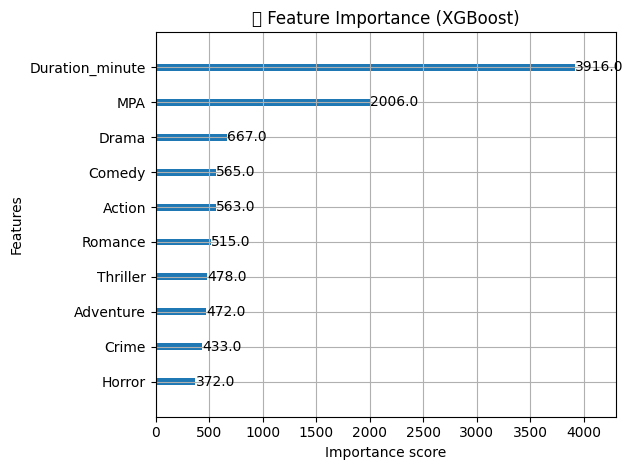

In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt
import ast

# ░░ 1. 전처리: MPA와 genres_imdb 인코딩 ░░

# MPA 범주형 인코딩
le = LabelEncoder()
df['MPA'] = le.fit_transform(df['MPA'].astype(str))


# ░░ 2. 입력/출력 설정 및 로그 변환 ░░
X = df.drop('popularity_score', axis=1)
y = np.log1p(df['popularity_score'])  # log(1 + y) 변환

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# ░░ 3. XGBoost 모델 및 파라미터 그리드 ░░
xgb_model = XGBRegressor(random_state=0)

param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [3, 5],
    'learning_rate': [0.03, 0.05],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [1, 1.5],
    'gamma': [0, 0.1],
    'min_child_weight': [3, 5]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# ░░ 4. 모델 학습 ░░
grid_search.fit(X_train, y_train)

# ░░ 5. 최적 파라미터 및 교차검증 결과 ░░
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_mse_cv = -grid_search.best_score_
best_rmse_cv = np.sqrt(best_mse_cv)

print("✅ 최적의 하이퍼파라미터:")
for param, value in best_params.items():
    print(f" - {param}: {value}")
print(f"\n📉 교차검증 평균 MSE : {best_mse_cv:.4f}")
print(f"📉 교차검증 평균 RMSE: {best_rmse_cv:.4f}")

# ░░ 6. 학습/테스트 예측 및 평가 ░░
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# 학습 성능
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# 테스트 성능
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# ░░ 7. 성능 출력 ░░
print("\n📚 학습셋 성능 (로그 스케일 기준)")
print(f" - MSE : {mse_train:.4f}")
print(f" - RMSE: {rmse_train:.4f}")
print(f" - MAE : {mae_train:.4f}")
print(f" - R²  : {r2_train:.4f}")

print("\n🧪 테스트셋 성능 (로그 스케일 기준)")
print(f" - MSE : {mse_test:.4f}")
print(f" - RMSE: {rmse_test:.4f}")
print(f" - MAE : {mae_test:.4f}")
print(f" - R²  : {r2_test:.4f}")

# ░░ 8. 중요도 시각화 ░░
plt.figure(figsize=(10, 6))
plot_importance(best_model, max_num_features=10)
plt.title("🎯 Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()


### np.expm1(3.0997) ≈ 22.21, 즉 약 22.2만의 오차

------

# 데이터 재정의

In [ ]:
df = pd.read_csv('movies_1980_2025.csv')

In [ ]:
df = df[[ 'MPA','Duration_minute', 'genres_imdb', 'popularity_score']]

# LightGBM Regressor

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['MPA'] = le.fit_transform(df['MPA'].astype(str))  # NaN 처리 포함

# 예시 - genres_imdb는 리스트 형태라면 MultiLabelBinarizer 사용
from sklearn.preprocessing import MultiLabelBinarizer

# 문자열 → 리스트로 먼저 변환 (예: '["Action", "Drama"]' → ['Action', 'Drama'])
import ast
df['genres_imdb'] = df['genres_imdb'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df['genres_imdb']), columns=mlb.classes_)

df = pd.concat([df.drop('genres_imdb', axis=1), genre_encoded], axis=1)



In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 공백 제거
df.columns = df.columns.str.replace(' ', '_')

X = df.drop('popularity_score', axis=1)
y = np.log1p(df['popularity_score'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 🔧 파라미터 수정
lgb_reg = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=64,
    min_child_samples=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=0
)

lgb_reg.fit(X_train, y_train)

# 역변환 예측
y_pred_test = np.expm1(lgb_reg.predict(X_test))
y_test_actual = np.expm1(y_test)

# 성능 출력
print("테스트 성능 (역변환 기준)")
print(f" RMSE: {mean_squared_error(y_test_actual, y_pred_test):,.2f}")
print(f" MAE : {mean_absolute_error(y_test_actual, y_pred_test):,.2f}")
print(f" R²  : {r2_score(y_test_actual, y_pred_test):.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 16140, number of used features: 24
[LightGBM] [Info] Start training from score 10.478343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

- 성능을 높이기 위해 하이퍼파라미터 변수를 추가, 조정하여 최고의 성능을 높이도록 했다.
- 문자열을 리스트로 변환하여 모델 학습 가능하도로고 변경하였다.